# Alb a 60 s

In [24]:
import numpy as np
import os
from astropy.io import fits
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
from IPython.display import Image
import glob

from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

In [25]:
alb_a_60s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\alb_a_60s002.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_60s00*.FIT")],
                        axis=0)
             )

In [26]:
alb_a_array = np.array(alb_a_60s_image_data)
alb_a_array = alb_a_array - np.median(alb_a_60s_image_data)

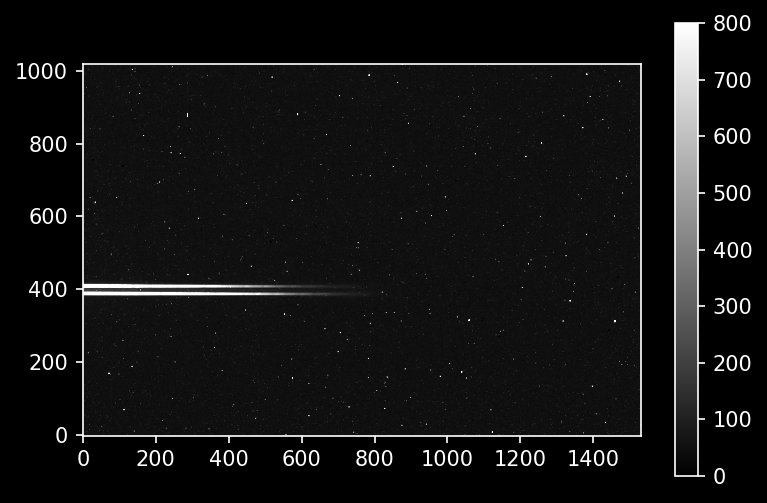

In [27]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(alb_a_60s_image_data, cmap='gray', vmax=0, vmin=800)
pl.colorbar()

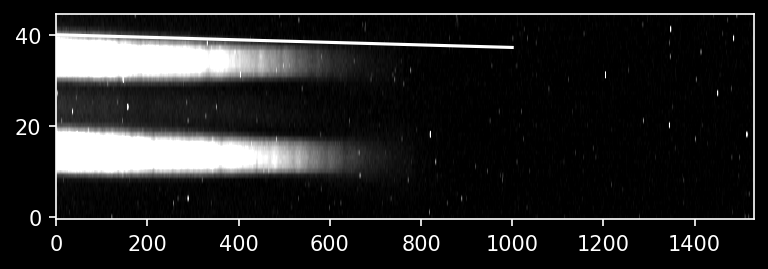

In [28]:
dy = -2.5
dx = 900
slope = dy/dx

ystart = 375
yend = 420

pl.imshow(alb_a_array[ystart:yend,:], cmap='gray', vmax=800, vmin=0)
pl.plot([0,1000], 40 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

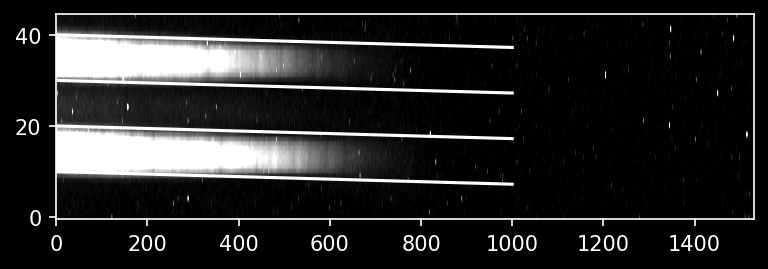

In [29]:
intertrace_cuts = np.array([10,20,30,40])
pl.imshow(alb_a_array[ystart:yend,:], cmap='gray', vmax=800, vmin=0)
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

In [30]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(alb_a_array.shape[1])
trace_center = ystart+(intertrace_cuts[2] + intertrace_cuts[3])/2 + xvals * slope
cutout_trace = np.array([alb_a_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

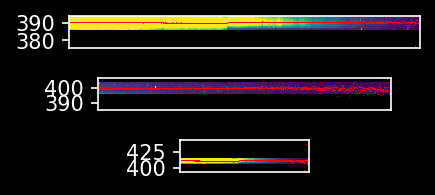

In [31]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(alb_a_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([alb_a_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut],vmax=800, vmin=0 )
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

(0.0, 800.0, 375.0, 420.0)

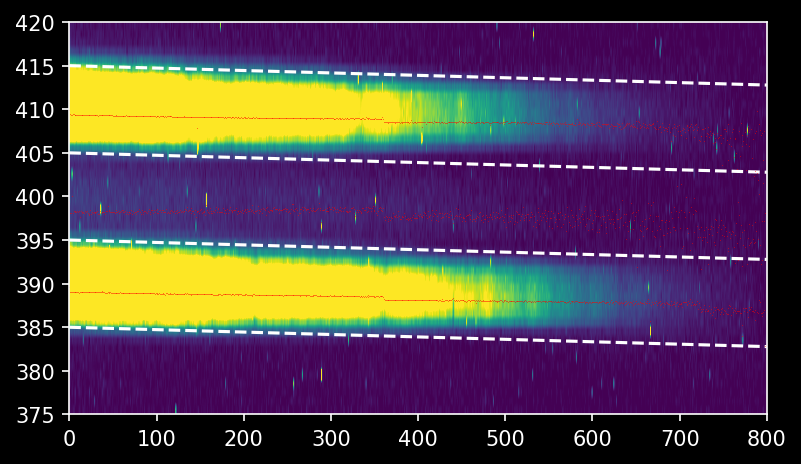

In [32]:
# then we can plot the "global" version here
pl.imshow(alb_a_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend], vmax=800, vmin=0)
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [33]:
traces = {key: traces[key] for key in [0,2]}

(0.0, 800.0, 375.0, 420.0)

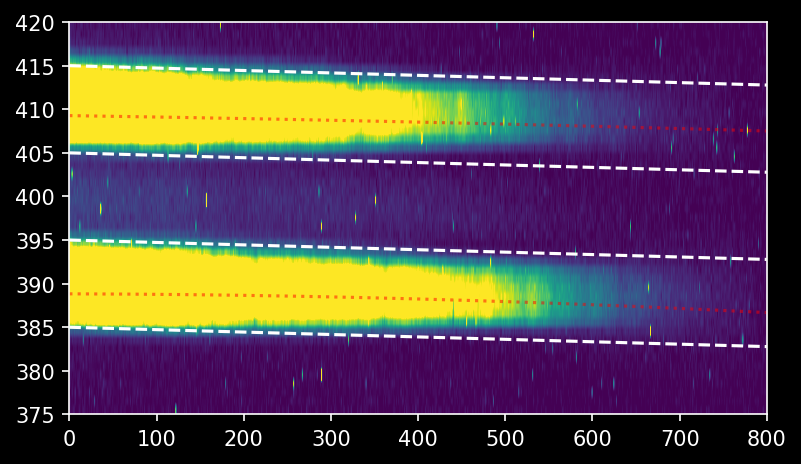

In [34]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(alb_a_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

(0.0, 800.0)

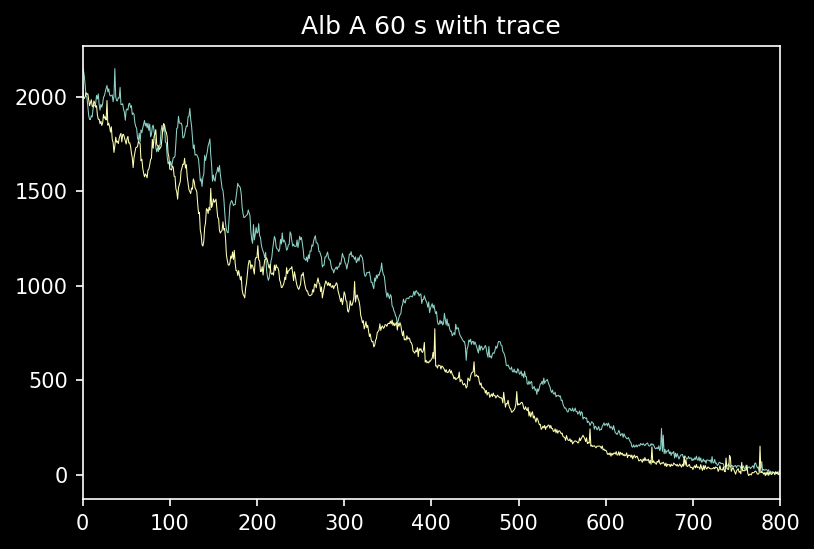

In [35]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([alb_a_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            alb_a_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Alb A 60 s with trace")
pl.xlim(0,800)

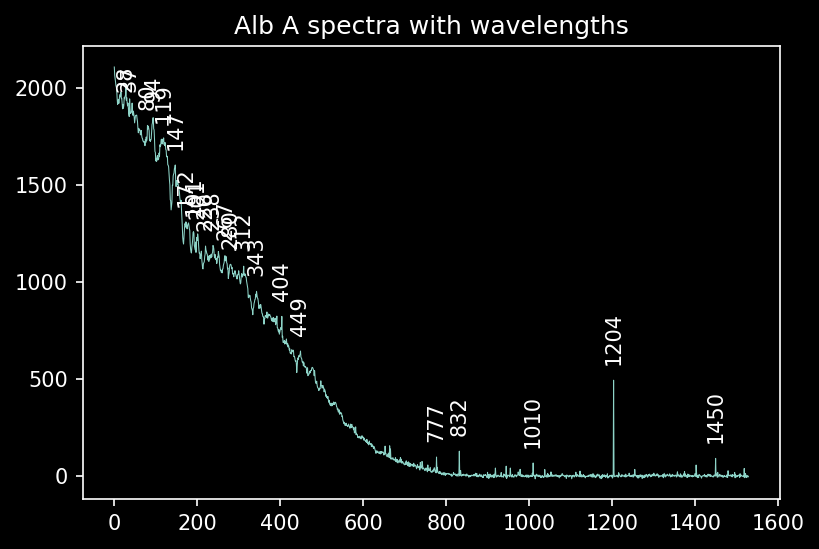

In [40]:
import scipy.signal

mean_he = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_he, linewidth = 0.5)
pl.title("Alb A spectra with wavelengths")

peaks,_ = scipy.signal.find_peaks(mean_he, prominence = 70)

for peak in peaks:
    pl.text(peak,
           min([mean_he[peak] + 100, 2000]), peak,
           rotation = 90, horizontalalignment = 'center',)
    

In [14]:
peaks

array([  16,   28,   37,   80,   94,  119,  147,  172,  191,  201,  220,
        238,  251,  267,  280,  312,  343,  368,  404,  449,  777,  832,
        945, 1010, 1204, 1403, 1450], dtype=int64)

# Alb B

In [15]:
alb_b_60s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\alb_b_60s002.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_60s00*.FIT")],
                        axis=0)
             )

alb_b_array = np.array(alb_b_60s_image_data)
alb_b_array = alb_b_array - np.median(alb_b_60s_image_data)

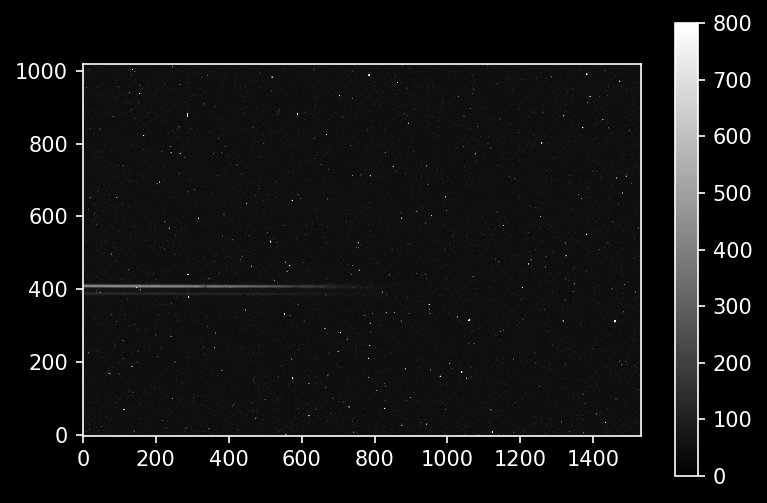

In [16]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(alb_b_60s_image_data, cmap='gray', vmax=0, vmin=800)
pl.colorbar()

In [17]:
traces = {key: traces[key] for key in [0,2]}

In [18]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

(0.0, 800.0, 375.0, 420.0)

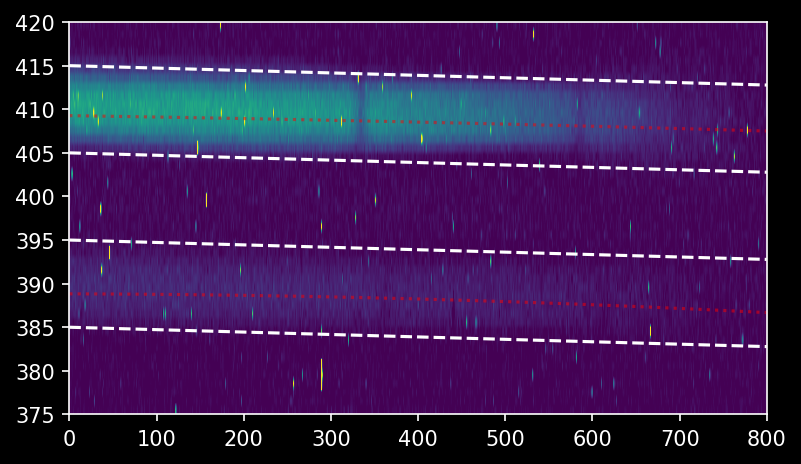

In [19]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(alb_b_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

(0.0, 800.0)

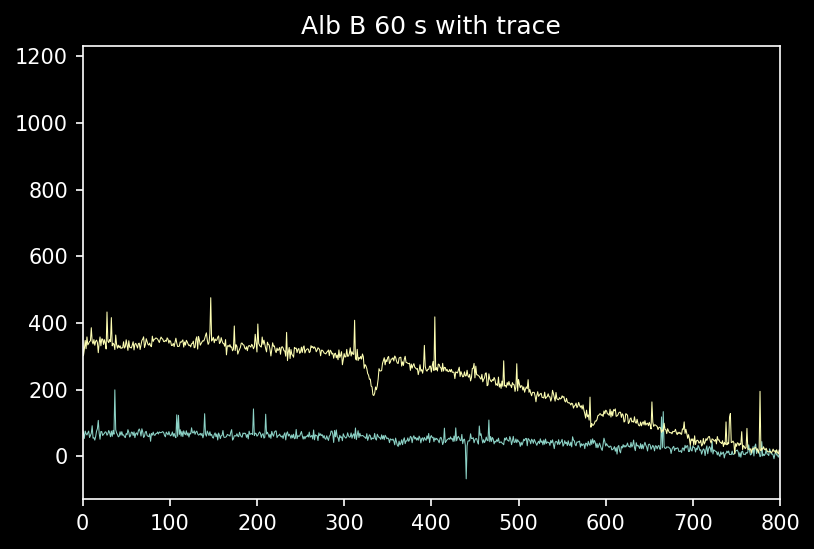

In [20]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([alb_b_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            alb_b_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Alb B 60 s with trace")
pl.xlim(0,800)

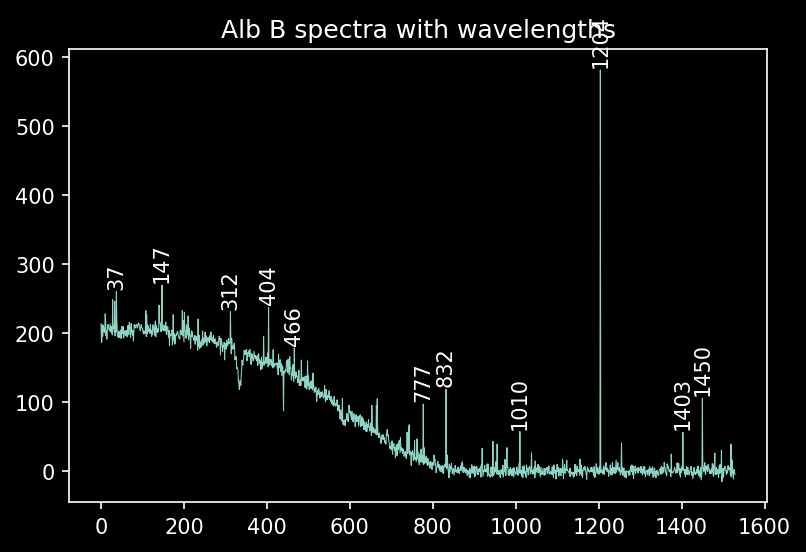

In [21]:
import scipy.signal

mean_he = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_he, linewidth = 0.5)
pl.title("Alb B spectra with wavelengths")

peaks,_ = scipy.signal.find_peaks(mean_he, prominence = 60)

for peak in peaks:
    pl.text(peak,
           min([mean_he[peak] + 10, 2000]), peak,
           rotation = 90, horizontalalignment = 'center',)

In [22]:
peaks

array([  37,  147,  312,  404,  466,  777,  832, 1010, 1204, 1403, 1450],
      dtype=int64)